# Fine-tunning DinoV2 model using F3 dataset

In this notebook we will fine-tune the DinoV2 using the F3 dataset.

The SFM model is a visual transformer model that is used for seismic interpretation. It comes in two versions: `ViT-Base` and `ViT-Large`.
- The ViT-Base model consists of 12 Transformer Layers, a Hidden size (D) of 768, an MLP size of 3072, and 12 heads. 
- The ViT-Large model comprises 24 Transformer Layers, a Hidden size (D) of 1024, an MLP size of 4096, and 16 heads.
We will going to use the `ViT-Base` model, which was pre-trained using 512x512 patches of seismic data. The checkpoint is given by the authors of the paper.

The F3 dataset is a 3D seismic dataset that is used for training and testing machine learning models for seismic interpretation. The dataset is composed of 2D TIFF images that represent seismic slices and 2D PNG images that represent the corresponding labels. 

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
import torch
import lightning as L
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from minerva.analysis.model_analysis import ModelAnalysis
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.loaders import FromPretrained
from minerva.models.nets.image.vit import ViT_Base_Patch16_Downstream_Regression
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from minerva.transforms.transform import _Transform, TransformPipeline
from minerva.utils.data import get_full_data_split

from lightning.pytorch.loggers.csv_logs import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import plotly.express as px
import plotly.graph_objects as go

import tqdm

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We  will create three transforms:
- `PadCrop`: to pad and crop the seismic and label images to the same size.
- `SelectChannel`: given a multi-channel image, it selects a single channel.
- `CastTo`: to cast the image to a specific data type.

In [2]:
class PadCrop(_Transform):
    """Transforms image and pads or crops it to the target size. 
    If the axis is larger than the target size, it will crop the image.
    If the axis is smaller than the target size, it will pad the image.
    """
    
    def __init__(
        self,
        target_h_size: int,
        target_w_size: int,
        padding_mode: str = "reflect",
        seed: int | None = None,
        constant_values: int = 0,
    ):
        """
        Initializes the transformation with target sizes, padding mode, and RNG seed.

        Parameters:
        - target_h_size (int): The target height size.
        - target_w_size (int): The target width size.
        - padding_mode (str): The padding mode to use (default is "reflect").
        - seed (int): Seed for random number generator to make cropping reproducible.
        """
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size
        self.padding_mode = padding_mode
        self.rng = np.random.default_rng(
            seed
        )  # Random number generator with the provided seed
        self.constant_values = constant_values

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        # print(f"-> [{self.__class__.__name__}] x.shape={x.shape}")

        # Handle height dimension independently: pad if target_h_size > h, else crop
        if self.target_h_size > h:
            pad_h = self.target_h_size - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            pad_args = {
                "array": x,
                "pad_width": (
                    ((pad_top, pad_bottom), (0, 0), (0, 0))
                    if len(x.shape) == 3
                    else ((pad_top, pad_bottom), (0, 0))
                ),
                "mode": self.padding_mode,
            }
            if self.padding_mode == "constant":
                pad_args["constant_values"] = self.constant_values
            
            x = np.pad(**pad_args)
            
        elif self.target_h_size < h:
            crop_h_start = self.rng.integers(0, h - self.target_h_size + 1)
            x = x[crop_h_start : crop_h_start + self.target_h_size, ...]

        # Handle width dimension independently: pad if target_w_size > w, else crop
        if self.target_w_size > w:
            pad_w = self.target_w_size - w
            pad_left = pad_w // 2
            pad_right = pad_w - pad_left
            
            pad_args = {
                "array": x,
                "pad_width": (
                    ((0, 0), (pad_left, pad_right), (0, 0))
                    if len(x.shape) == 3
                    else ((0, 0), (pad_left, pad_right))
                ),
                "mode": self.padding_mode,
            }
            
            if self.padding_mode == "constant":
                pad_args["constant_values"] = self.constant_values

            x = np.pad(**pad_args)
        
        elif self.target_w_size < w:
            crop_w_start = self.rng.integers(0, w - self.target_w_size + 1)
            x = x[:, crop_w_start : crop_w_start + self.target_w_size, ...]

        # Ensure channel dimension consistency
        if len(x.shape) == 2:  # For grayscale, add a channel dimension
            x = np.expand_dims(x, axis=2)

        # Convert to torch tensor with format C x H x W
        # output = torch.from_numpy(x).float()
        x = np.transpose(x, (2, 0, 1))  # Convert to C x H x W format
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        # print(f"<- [{self.__class__.__name__}] x.shape={x.shape}")
        return x


class SelectChannel(_Transform):
    """Perform a channel selection on the input image.
    """
    
    def __init__(self, channel: int, expand_channels: int = None):
        """
        Initializes the transformation with the channel to select.

        Parameters:
        - channel (int): The channel to select.
        """
        self.channel = channel
        self.expand_channels = expand_channels

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x =  x[self.channel, ...]
        if self.expand_channels is not None:
            x = np.expand_dims(x, axis=self.expand_channels)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x
    

class CastTo(_Transform):
    def __init__(self, dtype: type):
        """
        Initializes the transformation with the target data type.

        Parameters:
        - dtype (type): The target data type.
        """
        self.dtype = dtype

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x.astype(self.dtype)
    
    
class SwapAxes(_Transform):
    def __init__(self, source_axis: int, target_axis: int):
        """
        Initializes the transformation with the source and target axes.

        Parameters:
        - source_axis (int): The source axis to swap.
        - target_axis (int): The target axis to swap.
        """
        self.source_axis = source_axis
        self.target_axis = target_axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.swapaxes(x, self.source_axis, self.target_axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x
    
class RepeatChannel(_Transform):
    def __init__(self, repeats: int, axis: int):
        """
        Initializes the transformation with the number of repeats.

        Parameters:
        - repeats (int): The number of repeats.
        - axis (int): The axis to repeat.
        """
        self.repeats = repeats
        self.axis = axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.repeat(x, self.repeats, axis=self.axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x
    
    
class ExpandDims(_Transform):
    def __init__(self, axis: int):
        """
        Initializes the transformation with the axis to expand.

        Parameters:
        - axis (int): The axis to expand.
        """
        self.axis = axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.expand_dims(x, axis=self.axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x
    
class PerSampleTransformPipeline(TransformPipeline):
    def __init__(self, transforms):
        super().__init__(transforms)
        
    def __call__(self, x: np.ndarray) -> np.ndarray:
        new_values = []
        for i, value in enumerate(x):
            # print(f"-->[{self.__class__.__name__}] value[{i}].shape={value.shape}")
            value = super().__call__(value)
            # print(f"<--[{self.__class__.__name__}] value[{i}].shape={value.shape}")
            new_values.append(value)
        
        return np.array(new_values)

In [3]:
def plot_image(img, title=None, cmap: str = "gray"):
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.colorbar()
    plt.show()

In [4]:
import matplotlib.pyplot as plt


def plot_images(
    images,
    plot_title=None,
    subplot_titles=None,
    cmaps=None,
    filename=None,
    x_label=None,
    y_label=None,
    height=5,
    width=5,
    show=False
):
    num_images = len(images)

    # Create a figure with subplots (1 row, num_images columns), adjusting size based on height and width parameters
    fig, axs = plt.subplots(1, num_images, figsize=(width * num_images, height))

    # Set overall plot title if provided
    if plot_title is not None:
        fig.suptitle(plot_title, fontsize=16)

    # Ensure subplot_titles and cmaps are lists with correct lengths
    if subplot_titles is None:
        subplot_titles = [None] * num_images
    if cmaps is None:
        cmaps = ["gray"] * num_images

    # Plot each image in its respective subplot
    for i, (img, ax, title, cmap) in enumerate(
        zip(images, axs, subplot_titles, cmaps)
    ):
        im = ax.imshow(img, cmap=cmap)

        # Set title for each subplot if provided
        if title is not None:
            ax.set_title(title)

        # Add a colorbar for each subplot
        fig.colorbar(im, ax=ax)

        # Set x and y labels if provided
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)

    # Adjust layout to fit titles, labels, and colorbars
    plt.tight_layout()

    # Save the figure if filename is provided
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        print(f"Figure saved as '{filename}'")

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()

## Fine-tuning the model

We will fine-tune the model using the F3 dataset.

### 1. Defining the DataModule

First, we need to define the `DataModule` that will load the F3 dataset. We will going to create a LightningDataModule that will load the F3 dataset. The `DataModule` will have the following parameters:
- `root_data_dir`: the root directory where the F3 dataset is stored (TIFF images). In this directory, there are three subdirectories: `train`, `val`, and `test`.
- `root_annotation_dir`: the root directory where the labels are stored (PNG images). In this directory, there are three subdirectories: `train`, `val`, and `test`.
- `transforms`: a list of transforms to be applied to the seismic and label images.

Each image will be a tensor of shape `(1, H, W)`, where `H` and `W` are the height and width of the image, respectively.
We will use `HxW` as `(512, 512)` for the input size of the model. Thus, all dataloaders will return images/lables of size `(1, 512, 512)`.

In [5]:
from minerva.data.readers.reader import _Reader


class MultiReader(_Reader):
    def __init__(self, readers):
        self.readers = readers
        
    def __len__(self) -> int:
        return len(self.readers[0])

    def __getitem__(self, i) -> np.ndarray:
        r =  np.stack([reader[i] for reader in self.readers])
        # print(f"The shape of the reader is {r.shape}")
        return r


In [6]:
class GenericDataModule(L.LightningDataModule):
    def __init__(
        self,
        root_data_dir: str,
        root_annotation_dir: str,
        transforms,
        batch_size: int = 1,
        num_workers: Optional[int] = None,
    ):
        super().__init__()
        self.root_data_dir = Path(root_data_dir)
        self.root_annotation_dir = Path(root_annotation_dir)
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.root_data_dir / "train")
            train_label_reader = PNGReader(self.root_annotation_dir / "train")
            train_dataset = SupervisedReconstructionDataset(
                readers=[
                    MultiReader([train_img_reader, train_img_reader]),
                    MultiReader([train_label_reader, train_label_reader]),
                ],
                transforms=self.transforms,
            )

            val_img_reader = TiffReader(self.root_data_dir / "val")
            val_label_reader = PNGReader(self.root_annotation_dir / "val")
            val_dataset = SupervisedReconstructionDataset(
                readers=[
                    MultiReader([val_img_reader, val_img_reader]),
                    MultiReader([val_label_reader, val_label_reader]),
                ],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.root_data_dir / "test")
            test_label_reader = PNGReader(self.root_annotation_dir / "test")
            test_dataset = SupervisedReconstructionDataset(
                readers=[
                    MultiReader([test_img_reader, test_img_reader]),
                    MultiReader([test_label_reader, test_label_reader]),
                ],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def _get_dataloader(self, partition: str, shuffle: bool):
        return DataLoader(
            self.datasets[partition],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=shuffle,
        )

    def train_dataloader(self):
        return self._get_dataloader("train", shuffle=True)

    def val_dataloader(self):
        return self._get_dataloader("val", shuffle=False)

    def test_dataloader(self):
        return self._get_dataloader("test", shuffle=False)

    def predict_dataloader(self):
        return self._get_dataloader("predict", shuffle=False)

    def __str__(self) -> str:
        return f"""DataModule
    Data: {self.root_data_dir}
    Annotations: {self.root_annotation_dir}
    Batch size: {self.batch_size}"""

    def __repr__(self) -> str:
        return str(self)
    

We going to create our DataModule.

For data, we going to have the following transforms:
1. `PadCrop`: to pad and crop the seismic and label images `512x512`.
2. `SelectChannel`: to select the first channel of the seismic image and then expand the dimensions to `(1, 512, 512)`.
3. `CastTo`: to cast the seismic and label images to `np.float32`.

For labels, we going to have the following transforms:
1. `PadCrop`: to pad and crop the seismic and label images `512x512`.
2. `SelectChannel`: to select the first channel of the seismic image to have shape `(512, 512)`.
3. `CastTo`: to cast the seismic and label images to `np.int64`, as labels are integers.

In [7]:
root_data_dir = "/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images"
root_annotation_dir = "/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations"


data_module = GenericDataModule(
    root_data_dir=root_data_dir,
    root_annotation_dir=root_annotation_dir,
    transforms=[
        PerSampleTransformPipeline([
            SwapAxes(0, -1),
            SelectChannel(0),
            SwapAxes(0, 1),
            PadCrop(1008, 784, padding_mode="reflect", seed=42, constant_values=0),
            RepeatChannel(repeats=3, axis=0),
            CastTo(np.float32),
        ]), 

        PerSampleTransformPipeline([
            # SwapAxes(0, -1),
            PadCrop(1006, 782, padding_mode="reflect", seed=42, constant_values=0),
            CastTo(np.int64),
        ]), 
    ],
    batch_size=1,
    num_workers=1
)

data_module

DataModule
    Data: /workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images
    Annotations: /workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations
    Batch size: 1

### 2. Defining the Pre-trained DinoV2 model

We will going to create the VIT-Base model for downstream task, that will be fine-tuned using the F3 dataset.
The model use images of `(512, 512)` as input size, with 1 channel. The head will select from 6 classes.

For now, the model will be randomly initialized.

In [10]:
from minerva.models.ssl.dinov2 import (
    DinoVisionTransformer,
    SETR_PUP,
    NestedTensorBlock,
    MemEffAttention,
)
from functools import partial

backbone = DinoVisionTransformer(
    patch_size=14,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    block_fn=partial(NestedTensorBlock, attn_class=MemEffAttention),  # type: ignore
    init_values=1e-5,
    block_chunks=0,
)

head = SETR_PUP(embedding_dim=384, num_classes=6)

Initialized DinoVisionTransformer with img_size=224,
patch_size=14,
in_chans=3,
embed_dim=384,
depth=12,
num_heads=6,
mlp_ratio=4,
qkv_bias=True,
ffn_bias=True,
proj_bias=True,
drop_path_rate=0.0,
drop_path_uniform=False,
init_values=1e-05,
embed_layer=<class 'minerva.models.ssl.dinov2.PatchEmbed'>,
act_layer=<class 'torch.nn.modules.activation.GELU'>,
block_fn=functools.partial(<class 'minerva.models.ssl.dinov2.NestedTensorBlock'>, attn_class=<class 'minerva.models.ssl.dinov2.MemEffAttention'>),
ffn_layer=<class 'minerva.models.ssl.dinov2.Mlp'>,
block_chunks=0


In [11]:
class DinoV2(L.LightningModule):
    def __init__(self, backbone, head, loss_fn, n1, n2, emb_dim=384):
        super().__init__()
        self.backbone = backbone
        self.head = head
        self.loss_fn = loss_fn
        self.n1 = n1
        self.n2 = n2
        self.emb_dim = emb_dim
        self.metric = JaccardIndex(task="multiclass", num_classes=6)

    def forward(self, x):
        size = (self.n1, self.n2)
        # print(f"FORWARD: x.shape={x.shape}")
        B, _, H, W = x.shape
        features, _ = self.backbone.forward_features(x)
        # print(f"FORWARD: features['x_norm_patchtokens'].shape={features['x_norm_patchtokens'].shape}")
        fea_img = features["x_norm_patchtokens"]
        fea_img = fea_img.view(
            fea_img.size(0), int(H / 14), int(W / 14), self.emb_dim
        )
        fea_img = fea_img.permute(0, 3, 1, 2).contiguous()
        # print(f"FORWARD: fea_img.shape={fea_img.shape}")
        out = self.head(fea_img, size)
        # print(f"FORWARD: out.shape={out.shape}")
        return out

    def training_step(self, batch, batch_idx):
        data, label = batch
        b1, b2, c, h, w = data.shape
        data = data.reshape(b1 * b2, c, h, w)
        # print(f"[SYNC] data.shape={data.shape}")
        b1, b2, c, h, w = label.shape
        label = label.reshape(b1 * b2, h, w)
        # print(f"[SYNC] label.shape={label.shape}")
        outputs = self.forward(data)
        # print(f"[SYNC] outputs.shape={outputs.shape}")
        loss = self.loss_fn(outputs, label.long())
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data, label = batch
        b1, b2, c, h, w = data.shape
        data = data.reshape(b1 * b2, c, h, w)
        # print(f"[SYNC] data.shape={data.shape}")
        b1, b2, c, h, w = label.shape
        label = label.reshape(b1 * b2, h, w)
        # print(f"[SYNC] label.shape={label.shape}")
        outputs = self.forward(data)
        # print(f"[SYNC] outputs.shape={outputs.shape}")
        loss = self.loss_fn(outputs, label.long())
        
        # if args.loss == "bce":
        #     loss = criterion(
        #         outputs,
        #         label.unsqueeze(1).expand(-1, 2, -1, -1).float(),
        #     )
        # else:
        #     loss = criterion(outputs, label.long())
        self.log("val_loss", loss)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        data, label = batch
        b1, b2, c, h, w = data.shape
        data = data.reshape(b1 * b2, c, h, w)
        # print(f"[SYNC] data.shape={data.shape}")
        b1, b2, c, h, w = label.shape
        label = label.reshape(b1 * b2, h, w)
        # print(f"[SYNC] label.shape={label.shape}")
        outputs = self.forward(data)
        # print(f"[SYNC] outputs.shape={outputs.shape}")
        loss = self.loss_fn(outputs, label.long())
        
        self.metric = self.metric.to(self.device)
        return {
            "miou": self.metric(outputs, label.long())
        }
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer
    

In [12]:
model = DinoV2(
    backbone=backbone,
    head=head,
    loss_fn=torch.nn.CrossEntropyLoss(),
    n1=1006,
    n2=782
)

model

DinoV2(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
     

Now, lets load the model from a checkponint, using `FromPretrained` class.
This class will load the checkpoint from the `ckpt_path` and return the pre-trained model.
This class requires the following parameters:
- `model`: the instance of the model with randomlly initialized weights.
- `ckpt_path`: the path to the checkpoint file.
- `ckpt_key`: the name of `state_dict` variable in the checkpoint file.
- `filter_keys`: a list of keys to be removed from the checkpoint file before loading the model.
- `keys_to_rename`: a dictionary with keys to be renamed in the checkpoint file before loading the model.

For this model, we will going to use a pre-trained model provided by the authors of the paper (`/workspaces/HIAAC-KR-Dev-Container/shared_data/seismic_foundation_model/pretrained_models/SFM-Base-512.pth`). 
In this checkpoint file, the state_dict variable is named `model`, thus, we will set `ckpt_key='model'`. 
The filter_keys will only select the keys related to the backbone of the model, ignoring the head.
Finally, we use `keys_to_rename={"": "backbone.model."}` to rename the keys in the checkpoint file. Every key in the checkpoint file will be prefixed with `backbone.model.`.

Note that some `_IncompatibleKeys` may appear, but they are not a problem, as they are related to the head of the model, which will be discarded.

In [13]:
ckpt_file = "/workspaces/HIAAC-KR-Dev-Container/Minerva-Dev/docs/notebooks/examples/seismic/facies_classification/f3/dinov2_vits14_pretrain.pth"
ckpt = torch.load(ckpt_file, map_location="cpu")

/tmp/ipykernel_1684731/1669039306.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location="cpu")


In [14]:
model = FromPretrained(
    model=model,
    ckpt_path=ckpt_file,
    ckpt_key=None,
    strict=False,
    # filter_keys=["norm"],
    keys_to_rename={"": "backbone."},
    error_on_missing_keys=False
)

Model loaded from /workspaces/HIAAC-KR-Dev-Container/Minerva-Dev/docs/notebooks/examples/seismic/facies_classification/f3/dinov2_vits14_pretrain.pth
When loading model, the following keys are missing: ['head.decode_net.0.0.weight', 'head.decode_net.0.0.bias', 'head.decode_net.0.1.weight', 'head.decode_net.0.1.bias', 'head.decode_net.0.1.running_mean', 'head.decode_net.0.1.running_var', 'head.decode_net.0.3.weight', 'head.decode_net.0.3.bias', 'head.decode_net.0.4.weight', 'head.decode_net.0.4.bias', 'head.decode_net.0.4.running_mean', 'head.decode_net.0.4.running_var', 'head.decode_net.2.0.weight', 'head.decode_net.2.0.bias', 'head.decode_net.2.1.weight', 'head.decode_net.2.1.bias', 'head.decode_net.2.1.running_mean', 'head.decode_net.2.1.running_var', 'head.decode_net.2.3.weight', 'head.decode_net.2.3.bias', 'head.decode_net.2.4.weight', 'head.decode_net.2.4.bias', 'head.decode_net.2.4.running_mean', 'head.decode_net.2.4.running_var', 'head.decode_net.4.0.weight', 'head.decode_net.4.0

### 3. Defining the Trainer and Pipeline

Finall, we will define the Trainer and the Pipeline to fine-tune the model.

In [15]:
log_dir = "./logs"
logger = CSVLogger(log_dir, name="dinov2", version="parihaka")
checkpoint = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
)


trainer = L.Trainer(
    max_epochs=1,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint],
)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    log_dir=log_dir + "/f3_segmentation",
    save_run_status=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/seed.py:42: No seed found, seed set to 0
Seed set to 0


Log directory set to: /workspaces/HIAAC-KR-Dev-Container/Minerva-Dev/docs/notebooks/examples/seismic/facies_classification/f3/logs/f3_segmentation


And fit the model using the pipeline

In [ ]:
# pipeline.run(data_module, task="fit")

In [16]:
new_ckpt = "logs/dinov2/parihaka/checkpoints/last-v1.ckpt"
model.load_state_dict(torch.load(new_ckpt, map_location="cpu")["state_dict"])

/tmp/ipykernel_1684731/2329185883.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(new_ckpt, map_location="cpu")["state_dict"])


<All keys matched successfully>

Testing: 0it [00:00, ?it/s]

Figure saved as 'logs/dinov2/parihaka/segmentation_0.png'


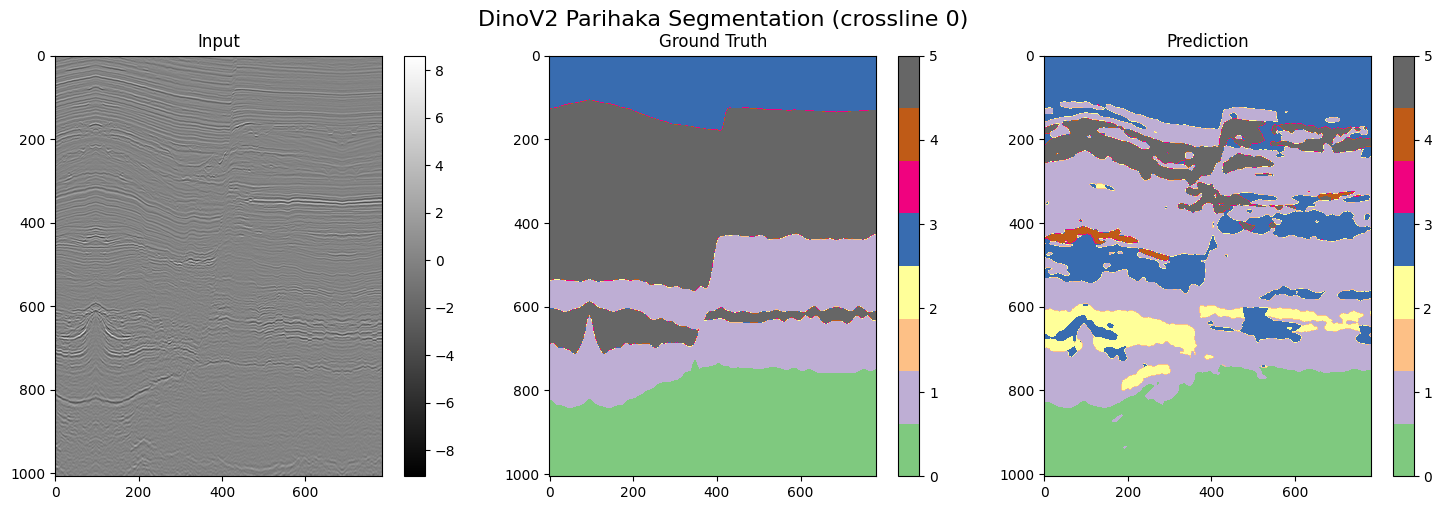

Testing: 52it [00:12,  3.08it/s]

Figure saved as 'logs/dinov2/parihaka/segmentation_50.png'


Testing: 103it [00:19,  3.85it/s]

Figure saved as 'logs/dinov2/parihaka/segmentation_100.png'


Testing: 153it [00:26,  3.63it/s]

Figure saved as 'logs/dinov2/parihaka/segmentation_150.png'


Testing: 200it [00:30,  6.48it/s]


In [17]:
data_module.setup("test")
miou_metric = JaccardIndex(task="multiclass", num_classes=6).to("cuda")

model.eval()
model = model.to("cuda")

metric_values = []
for i, (x, y) in tqdm.tqdm(
    enumerate(data_module.test_dataloader()),
    desc="Testing",
    leave=True,
):
    b1, b2, c, h, w = x.shape
    x = x.reshape(b1 * b2, c, h, w)
    x = x.to("cuda")
    y_hat = model.forward(x)

    y_hat = y_hat[0]
    y_hat = torch.argmax(y_hat, dim=0)
    y = y[0][0][0]
    y = y.to("cuda")

    res = miou_metric(y_hat, y)
    metric_values.append(res.item())

    if i % 50 == 0:
        plot_images(
            images=[
                x[0][0].cpu().numpy(),
                y.cpu().numpy(),
                y_hat.cpu().numpy(),
            ],
            subplot_titles=["Input", "Ground Truth", "Prediction"],
            cmaps=["gray", "Accent", "Accent"],
            plot_title=f"DinoV2 Parihaka Segmentation (crossline {i})",
            filename=f"logs/dinov2/parihaka/segmentation_{i}.png",
            show=(i == 0),
        )

In [19]:
mean_iou = np.mean(metric_values)
print(f"Mean IoU: {np.mean(metric_values)*100:.2f}%")

Mean IoU: 63.76%


## Evaluation


We will evaluate the model using the test dataset. The `SimpleLightningPipeline` class allows us to easily provide classification metrics for the test dataset, such as Mean IoU, using torchmetrics API. The `classification_metrics` parameter is a dictionary  where keys are the names of the metrics and values are the instances of the metrics to be calculated. In this case, we will calculate the Mean IoU (`JaccardIndex` from `torchmetrics`).

The `SimpleLightningPipeline` class also allows us to easily provide tools to analyze the model's predictions. The `model_analysis` parameter is a dictionary where keys are the names of the analysis tools and values are the instances of the analysis tools to be used. Tools should be instances derived from the `ModelAnalysis` class, which implements the `compute` method that receives the model and the dataloader and returns the results of the analysis. This is quite useful for plotting the model's predictions and the ground truth labels side by side.

In [ ]:
# class ImShow(ModelAnalysis):
#     def __init__(self, indices: list, cmap="gray", show: bool = False):
#         self.indices = indices
#         self.cmap = cmap
#         self.show = show
#         self.label_cmap = ListedColormap(
#             [
#                 [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
#                 [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
#                 [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
#                 [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
#                 [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
#                 [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
#             ]
#         )
        
#     def compute(self, model: L.LightningModule, data: L.LightningDataModule):
#         if not self.path:
#             raise ValueError(
#                 "Path is not set. Please set the path before running the analysis."
#             )

#         model.eval()
#         X, y = get_full_data_split(data, "predict")
#         _X, _y = [], []
#         for idx in self.indices:
#             _X.append(X[idx])
#             _y.append(y[idx])
            
#         X = np.array(_X)
#         y = np.array(_y)
        
#         X = torch.tensor(X, device="cpu")
#         y = torch.tensor(y, device="cpu")
        
#         embeddings = model.backbone.forward(X)  # type: ignore
#         embeddings = torch.argmax(embeddings, dim=1)
        
#         paths = {}
        
#         for i in range(len(X)):
#             no = self.indices[i]
#             x = X[i].cpu().squeeze().numpy()
#             y = y[i].cpu().numpy()
#             pred = embeddings[i].cpu().numpy()
#             fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#             ax[0].imshow(x, cmap=self.cmap)
#             ax[0].set_title("Input Image")
#             ax[1].imshow(y, cmap=self.label_cmap)
#             ax[1].set_title("Ground Truth")
#             ax[2].imshow(pred, cmap=self.label_cmap)
#             ax[2].set_title("Predicted")
#             fig_path = self.path / f"image_{no}.png"
#             paths[no] = fig_path
#             plt.savefig(fig_path)
#             print(f"Saved figure to {fig_path}")
#             if self.show:
#                 plt.show()
#             plt.close(fig)
            
#         return paths

# pipeline = SimpleLightningPipeline(
#     model=model,
#     trainer=trainer,
#     log_dir=log_dir + "/f3_segmentation",
#     save_run_status=False,
#     classification_metrics={
#         "miou": JaccardIndex(task="multiclass", num_classes=6)
#     },
# )

In [ ]:
# pipeline.run(data_module, task="evaluate")